# Training for Crop disease

In [17]:
import os
import shutil
import random

# Correct path (go one level up from notebooks)
base_dir = os.path.join('..', 'datasets', 'crop', 'PlantVillage')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

classes = ['Healthy', 'Diseased']
split_size = 0.8  # 80% train / 20% val
valid_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

# Create destination folders
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

def gather_images_from_subfolders(class_src_dir):
    """
    Gathers all image paths (recursively) under each crop subfolder.
    """
    items = []
    for entry in os.listdir(class_src_dir):
        subfolder = os.path.join(class_src_dir, entry)
        if os.path.isdir(subfolder):
            for fname in os.listdir(subfolder):
                fpath = os.path.join(subfolder, fname)
                if os.path.isfile(fpath) and os.path.splitext(fname.lower())[1] in valid_exts:
                    items.append(fpath)
    return items

def split_and_copy(class_name):
    src_class_dir = os.path.join(base_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)

    images = gather_images_from_subfolders(src_class_dir)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * split_size)
    train_imgs = images[:n_train]
    val_imgs = images[n_train:]

    # Copy files
    for img in train_imgs:
        shutil.copy(img, train_class_dir)
    for img in val_imgs:
        shutil.copy(img, val_class_dir)

    print(f"\n📂 {class_name}")
    print(f"  Total images: {n_total}")
    print(f"  → Train: {len(train_imgs)} → {train_class_dir}")
    print(f"  → Val:   {len(val_imgs)} → {val_class_dir}")

# Run splitting for each class
for cls in classes:
    split_and_copy(cls)

# Verify counts
def count_images(path):
    count = 0
    for root, _, files in os.walk(path):
        count += len([f for f in files if os.path.splitext(f.lower())[1] in valid_exts])
    return count

print("\n✅ Verification Summary:")
for cls in classes:
    print(f"  {cls}: Train={count_images(os.path.join(train_dir, cls))}, Val={count_images(os.path.join(val_dir, cls))}")

print("\n🎯 Dataset successfully split into Train and Validation folders!")



📂 Healthy
  Total images: 3221
  → Train: 2576 → ..\datasets\crop\PlantVillage\train\Healthy
  → Val:   645 → ..\datasets\crop\PlantVillage\val\Healthy

📂 Diseased
  Total images: 17417
  → Train: 13933 → ..\datasets\crop\PlantVillage\train\Diseased
  → Val:   3484 → ..\datasets\crop\PlantVillage\val\Diseased

✅ Verification Summary:
  Healthy: Train=2576, Val=645
  Diseased: Train=13933, Val=3484

🎯 Dataset successfully split into Train and Validation folders!


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Base paths (keep same as used earlier)
train_dir = os.path.join('..', 'datasets', 'crop', 'PlantVillage', 'train')
val_dir = os.path.join('..', 'datasets', 'crop', 'PlantVillage', 'val')

# Data augmentation for training, simple rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # normalize pixel values
    rotation_range=20,           # random rotation
    width_shift_range=0.1,       # horizontal shift
    height_shift_range=0.1,      # vertical shift
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,        # random horizontal flip
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # since we have 2 classes
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

print("✅ Data generators are ready!")


Found 16509 images belonging to 2 classes.
Found 4129 images belonging to 2 classes.
✅ Data generators are ready!


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Build the CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # sigmoid for binary classification
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


d:\Agri 4.0\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Step 6: Train the CNN model
EPOCHS = 20  # You can increase later (try 25–30 for better accuracy)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 324s 628ms/step - accuracy: 0.9787 - loss: 0.0645 - val_accuracy: 0.8203 - val_loss: 0.4891
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 364s 705ms/step - accuracy: 0.9781 - loss: 0.0634 - val_accuracy: 0.7786 - val_loss: 0.7011
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 309s 599ms/step - accuracy: 0.9805 - loss: 0.0570 - val_accuracy: 0.8745 - val_loss: 0.3329
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 286s 555ms/step - accuracy: 0.9846 - loss: 0.0475 - val_accuracy: 0.8474 - val_loss: 0.4869
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 301s 584ms/step - accuracy: 0.9841 - loss: 0.0482 - val_accuracy: 0.8351 - val_loss: 0.4588
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 341s 660ms/step - accuracy: 0.9872 - loss: 0.0427 - val_accuracy: 0.9005 - val_loss: 0.2908
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 288s 557ms/step - accuracy: 0.9873 - loss: 0.0418 - val_accuracy: 0.8682 - val_loss: 0.3705
Epoch 8/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 400s 775ms/step - accuracy: 0.9882 -

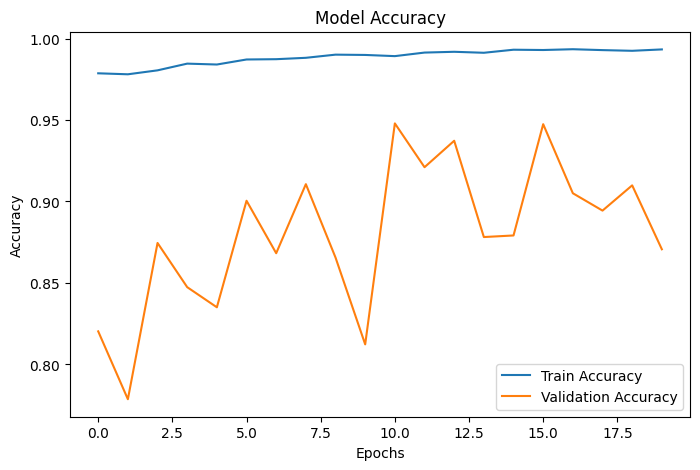

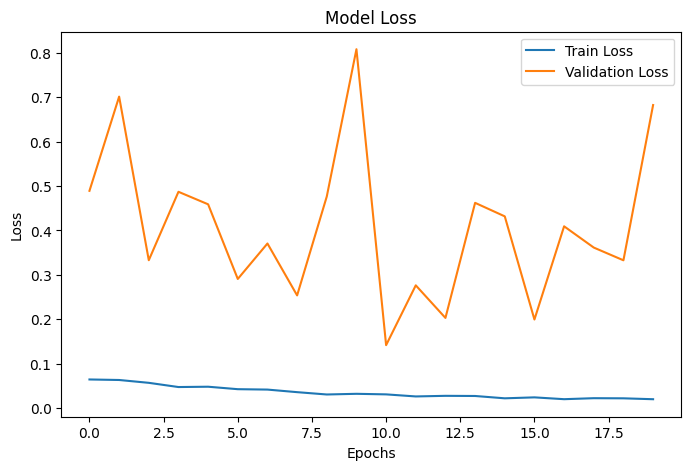

In [33]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
model.save('../models/crop_model.h5')
print("✅ Model saved successfully at ../models/crop_model.h5")


NameError: name 'model' is not defined

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

model = tf.keras.models.load_model('../models/crop_model.h5')

# Test image (change path to one from your dataset)
img_path = '../datasets/pest/images/val/sample.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
pred_class = "Diseased" if prediction[0][0] > 0.5 else "Healthy"
confidence = prediction[0][0] if pred_class == "Diseased" else 1 - prediction[0][0]

print(f"🌿 Predicted: {pred_class} (Confidence: {confidence:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
🌿 Predicted: Diseased (Confidence: 1.00)
